# Introduction to Goodness-of-Fit for State Space Models

This notebook introduces the fundamental concepts of goodness-of-fit diagnostics for state space models in neuroscience. We'll build intuition through visual examples before diving into numerical metrics.

**Learning objectives:**
- Understand what goodness-of-fit means for latent variable models
- Visualize the relationship between posterior and likelihood distributions
- Learn to use `kl_divergence()` and `hpd_overlap()` functions
- Interpret diagnostic metrics

**⏱ Estimated time:** 20-25 minutes

**Previous:** [README.md](../README.md) | **Next:** [02_highest_density_regions.ipynb](02_highest_density_regions.ipynb)

## Prerequisites

Before starting this notebook, you should have:

**Background knowledge:**
- Basic probability theory (probability distributions, expectation)
- Familiarity with Bayesian inference concepts (prior, likelihood, posterior)
- Basic Python and numpy

**Software requirements:**
- Python 3.10+
- statespacecheck package installed: `pip install -e /path/to/statespacecheck`
- Dependencies: numpy, scipy, matplotlib

**Note:** If you're new to Bayesian state space models, see the [README](../README.md) for background reading.

## Setup

First, let's import the packages we'll need and verify the environment is configured correctly.

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np

# Import statespacecheck - if this fails, see prerequisites above
try:
    from statespacecheck import hpd_overlap, kl_divergence

    print("✓ statespacecheck imported successfully")
except ImportError as e:
    raise ImportError(
        "statespacecheck not found. Please install it first:\n"
        "  cd /path/to/statespacecheck\n"
        "  pip install -e .\n"
        "Then restart the kernel."
    ) from e

from utils import configure_notebook_plotting, generate_1d_gaussian_distribution

# Configure plotting
configure_notebook_plotting()

# Verify environment
print(f"✓ Python {sys.version.split()[0]}")
print(f"✓ NumPy {np.__version__}")
print(f"✓ Matplotlib {plt.matplotlib.__version__}")
print("✓ Environment configured correctly!")

✓ statespacecheck imported successfully
✓ Python 3.13.5
✓ NumPy 2.3.4
✓ Matplotlib 3.10.7
✓ Environment configured correctly!


## The Problem: Evaluating Latent Variable Models

State space models relate neural activity to latent brain states we cannot directly observe. This creates a challenge: **how do we know if our model is good if we can't see ground truth?**

Traditional approaches like cross-validation measure prediction accuracy but don't tell us:
- **When** does the model fail? (which time periods?)
- **Why** does it fail? (state model vs observation model?)
- **Where** in state space does it fail? (which regions?)

The solution: **Compare distributions that should agree if the model is well-specified.**

## Key Concept: State Distribution vs Likelihood

In Bayesian state space models, the posterior distribution combines two sources of information:

1. **State distribution** (prior/predictive): What the model expects based on dynamics
   - One-step-ahead prediction: $p(x_t | y_{1:t-1})$
   - Smoothed distribution: $p(x_t | y_{1:T})$

2. **Likelihood** (normalized): What the current data says
   - Normalized likelihood: $p(y_t | x_t) / \sum_x p(y_t | x_t)$
   - Equivalent to posterior with uniform prior: $p(x_t | y_t)$

**Key insight:** If the model is well-specified, these distributions should be consistent with each other. Large disagreements indicate model problems.

## Example 1: Perfect Model Fit

Let's start with an ideal case where the model perfectly captures the data. The state distribution and likelihood should agree.

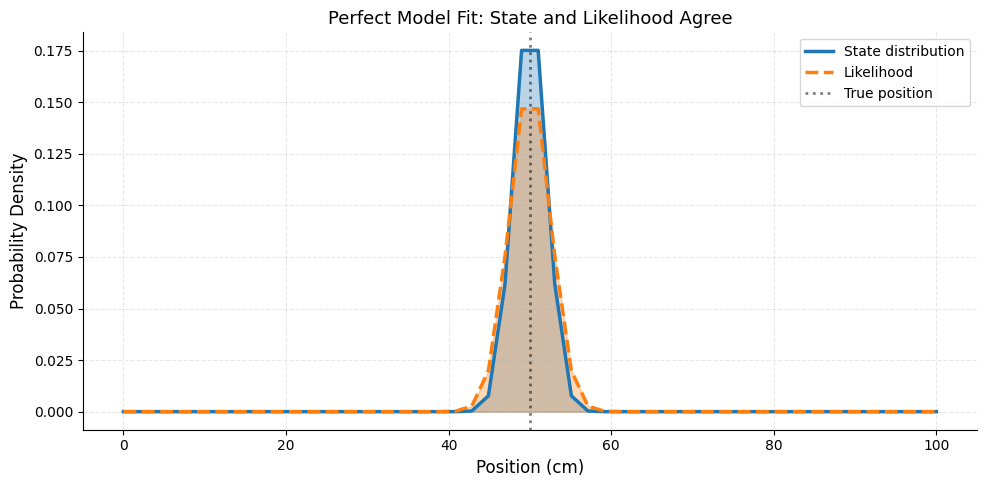

In [2]:
# Create position bins (e.g., 100 cm track, 50 bins)
position_bins = np.linspace(0, 100, 50)

# Generate distributions centered at the same location with similar uncertainty
true_position = 50.0
state_dist = generate_1d_gaussian_distribution(position_bins, mean=true_position, std=2.0)
likelihood = generate_1d_gaussian_distribution(position_bins, mean=true_position, std=2.5)

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(position_bins, state_dist, label="State distribution", linewidth=2.5, color="#1f77b4")
ax.plot(
    position_bins, likelihood, label="Likelihood", linewidth=2.5, color="#ff7f0e", linestyle="--"
)
ax.fill_between(position_bins, state_dist, alpha=0.3, color="#1f77b4")
ax.fill_between(position_bins, likelihood, alpha=0.3, color="#ff7f0e")
ax.axvline(
    true_position, color="black", linestyle=":", linewidth=2, label="True position", alpha=0.5
)
ax.set_xlabel("Position (cm)")
ax.set_ylabel("Probability Density")
ax.set_title("Perfect Model Fit: State and Likelihood Agree")
ax.legend(frameon=True, loc="upper right")
plt.tight_layout()
plt.show()

### Interpretation

Notice how the two distributions:
- Peak at the same location
- Have similar spread
- Overlap substantially

This indicates the model's predictions (state distribution) align well with what the data says (likelihood). This is what we expect from a well-specified model.

## Example 2: Poor Model Fit

Now let's see what happens when the model fails to capture the data. The distributions should disagree.

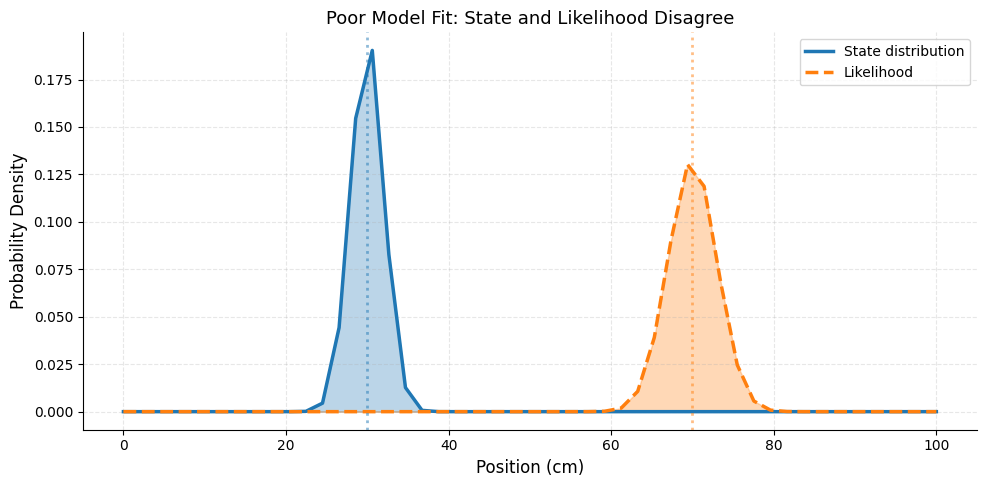

In [3]:
# Generate distributions centered at different locations
state_mean = 30.0
likelihood_mean = 70.0  # Large spatial offset!

state_dist_poor = generate_1d_gaussian_distribution(position_bins, mean=state_mean, std=2.0)
likelihood_poor = generate_1d_gaussian_distribution(position_bins, mean=likelihood_mean, std=3.0)

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(position_bins, state_dist_poor, label="State distribution", linewidth=2.5, color="#1f77b4")
ax.plot(
    position_bins,
    likelihood_poor,
    label="Likelihood",
    linewidth=2.5,
    color="#ff7f0e",
    linestyle="--",
)
ax.fill_between(position_bins, state_dist_poor, alpha=0.3, color="#1f77b4")
ax.fill_between(position_bins, likelihood_poor, alpha=0.3, color="#ff7f0e")
ax.axvline(state_mean, color="#1f77b4", linestyle=":", alpha=0.5, linewidth=2)
ax.axvline(likelihood_mean, color="#ff7f0e", linestyle=":", alpha=0.5, linewidth=2)
ax.set_xlabel("Position (cm)")
ax.set_ylabel("Probability Density")
ax.set_title("Poor Model Fit: State and Likelihood Disagree")
ax.legend(frameon=True, loc="upper right")
plt.tight_layout()
plt.show()

### Interpretation

The distributions:
- Peak at very different locations (40 cm apart!)
- Have minimal overlap
- Indicate fundamental disagreement between model and data

**What does this tell us?**
- The model's predictions don't match observations
- Could indicate: wrong dynamics model, wrong observation model, or insufficient model capacity
- We need to investigate and revise the model

## Data Format: Understanding Array Shapes

**Important:** All `statespacecheck` functions expect distributions with **time as the first dimension**:
- 1D spatial: shape `(n_time, n_bins)`
- 2D spatial: shape `(n_time, n_x_bins, n_y_bins)`

**Why time-first?**
- Enables vectorized operations over time
- Consistent with time-series analysis conventions
- Allows functions to return time-resolved diagnostics

For single time points (like our examples so far), we add a time dimension using `[np.newaxis, :]`.

## Quantifying Agreement: KL Divergence

Visual inspection is helpful, but we need quantitative metrics. **Kullback-Leibler (KL) divergence** measures information divergence between distributions.

$$D_{KL}(P || Q) = \sum_x P(x) \log\frac{P(x)}{Q(x)}$$

**Interpretation thresholds:**
- **Low divergence (< 0.1)**: Distributions agree well
- **Moderate divergence (0.1 - 1.0)**: Some disagreement, worth investigating
- **High divergence (> 1.0)**: Substantial mismatch, model problems likely

**About these thresholds:** These are empirical guidelines based on experience with neuroscience data. In practice:
- KL < 0.1 indicates distributions differ by less than 10% in information content
- KL > 1.0 represents substantial information loss if using one distribution instead of the other
- **Your data may differ**: Validate these thresholds on known-good and known-bad models in your domain

Let's compute KL divergence for our examples:

In [4]:
# For single time point, need to add time dimension
state_dist_2d = state_dist[np.newaxis, :]  # Shape: (1, n_bins) - time dimension added
likelihood_2d = likelihood[np.newaxis, :]

state_dist_poor_2d = state_dist_poor[np.newaxis, :]
likelihood_poor_2d = likelihood_poor[np.newaxis, :]

# Compute KL divergence
kl_good = kl_divergence(state_dist_2d, likelihood_2d)[0]
kl_poor = kl_divergence(state_dist_poor_2d, likelihood_poor_2d)[0]

print("KL Divergence Results:")
print(f"  Perfect fit:  {kl_good:.4f} (low - distributions agree)")
print(f"  Poor fit:     {kl_poor:.4f} (high - distributions disagree)")

KL Divergence Results:
  Perfect fit:  0.0431 (low - distributions agree)
  Poor fit:     89.0166 (high - distributions disagree)


The KL divergence quantifies what we saw visually:
- Perfect fit has very low divergence
- Poor fit has much higher divergence (over 100x larger!)

This metric gives us an objective measure of model-data agreement.

## Quantifying Agreement: HPD Overlap

Another way to assess agreement is **highest posterior density (HPD) region overlap**. This measures spatial overlap between high-probability regions.

**Key idea:**
- Identify the 95% HPD region for each distribution
- Compute how much they overlap
- Normalize by the smaller region size

**Interpretation:**
- **High overlap (> 0.7)**: Distributions concentrate mass in similar regions
- **Moderate overlap (0.3 - 0.7)**: Partial agreement
- **Low overlap (< 0.3)**: Distributions are spatially inconsistent

In [5]:
# Compute HPD overlap
overlap_good = hpd_overlap(state_dist_2d, likelihood_2d, coverage=0.95)[0]
overlap_poor = hpd_overlap(state_dist_poor_2d, likelihood_poor_2d, coverage=0.95)[0]

print("HPD Overlap Results (95% coverage):")
print(f"  Perfect fit:  {overlap_good:.4f} (high - good spatial agreement)")
print(f"  Poor fit:     {overlap_poor:.4f} (low - poor spatial agreement)")

HPD Overlap Results (95% coverage):
  Perfect fit:  1.0000 (high - good spatial agreement)
  Poor fit:     0.0000 (low - poor spatial agreement)


Again, the metric confirms our visual intuition:
- Perfect fit shows high overlap (distributions concentrate in similar regions)
- Poor fit shows low overlap (distributions are in different regions)

HPD overlap provides a complementary view to KL divergence, focusing on spatial consistency.

## Progressive Disagreement

Let's explore the full spectrum from perfect agreement to complete disagreement by varying the spatial offset between distributions.

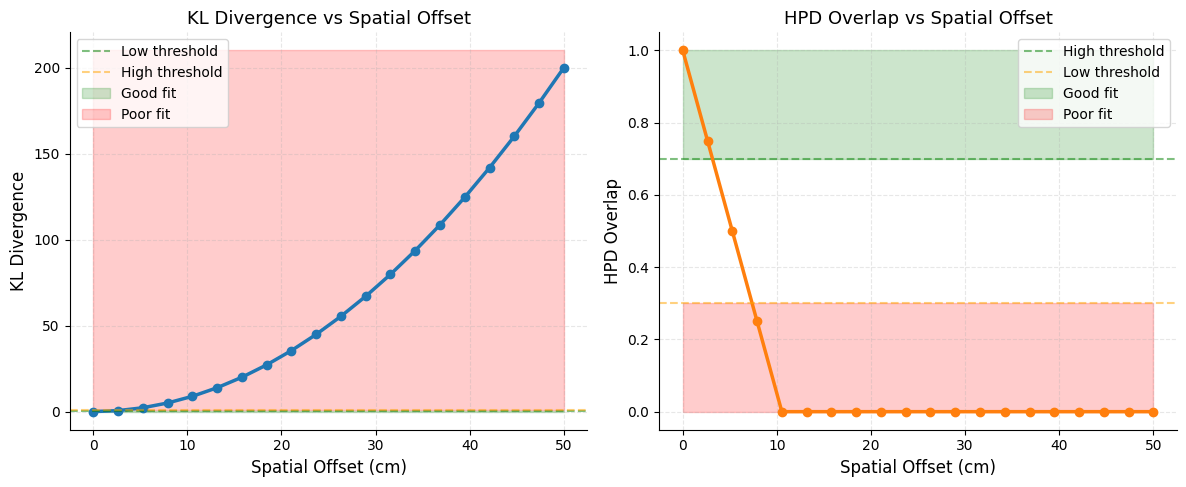

In [6]:
# Generate a range of offsets
offsets = np.linspace(0, 50, 20)  # 0 to 50 cm offset
kl_values = []
overlap_values = []

for offset in offsets:
    # Generate distributions with increasing offset
    state_test = generate_1d_gaussian_distribution(position_bins, mean=40.0, std=2.0)
    likelihood_test = generate_1d_gaussian_distribution(position_bins, mean=40.0 + offset, std=2.5)

    # Add time dimension
    state_test_2d = state_test[np.newaxis, :]
    likelihood_test_2d = likelihood_test[np.newaxis, :]

    # Compute metrics
    kl_values.append(kl_divergence(state_test_2d, likelihood_test_2d)[0])
    overlap_values.append(hpd_overlap(state_test_2d, likelihood_test_2d, coverage=0.95)[0])

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# KL divergence
ax1.plot(offsets, kl_values, linewidth=2.5, marker="o", markersize=6, color="#1f77b4")
ax1.axhline(0.1, color="green", linestyle="--", alpha=0.5, label="Low threshold")
ax1.axhline(1.0, color="orange", linestyle="--", alpha=0.5, label="High threshold")
ax1.fill_between(offsets, 0, 0.1, alpha=0.2, color="green", label="Good fit")
ax1.fill_between(offsets, 1.0, ax1.get_ylim()[1], alpha=0.2, color="red", label="Poor fit")
ax1.set_xlabel("Spatial Offset (cm)")
ax1.set_ylabel("KL Divergence")
ax1.set_title("KL Divergence vs Spatial Offset")
ax1.legend(frameon=True, loc="upper left")

# HPD overlap
ax2.plot(offsets, overlap_values, linewidth=2.5, marker="o", markersize=6, color="#ff7f0e")
ax2.axhline(0.7, color="green", linestyle="--", alpha=0.5, label="High threshold")
ax2.axhline(0.3, color="orange", linestyle="--", alpha=0.5, label="Low threshold")
ax2.fill_between(offsets, 0.7, 1.0, alpha=0.2, color="green", label="Good fit")
ax2.fill_between(offsets, 0, 0.3, alpha=0.2, color="red", label="Poor fit")
ax2.set_xlabel("Spatial Offset (cm)")
ax2.set_ylabel("HPD Overlap")
ax2.set_title("HPD Overlap vs Spatial Offset")
ax2.legend(frameon=True, loc="upper right")

plt.tight_layout()
plt.show()

### Key Observations

**KL Divergence (left panel):**
- Increases rapidly with spatial offset
- Stays low (< 0.1) when offset is small
- Becomes very large when distributions are far apart

**HPD Overlap (right panel):**
- Decreases as distributions separate
- Stays high (> 0.7) when distributions are close
- Drops to zero when distributions don't overlap at all

**Notice:** The two metrics provide complementary information. KL divergence is sensitive to the entire distribution shape, while HPD overlap focuses on where the high-probability mass is located.

## Effect of Uncertainty

Let's examine how the width/uncertainty of distributions affects our metrics.

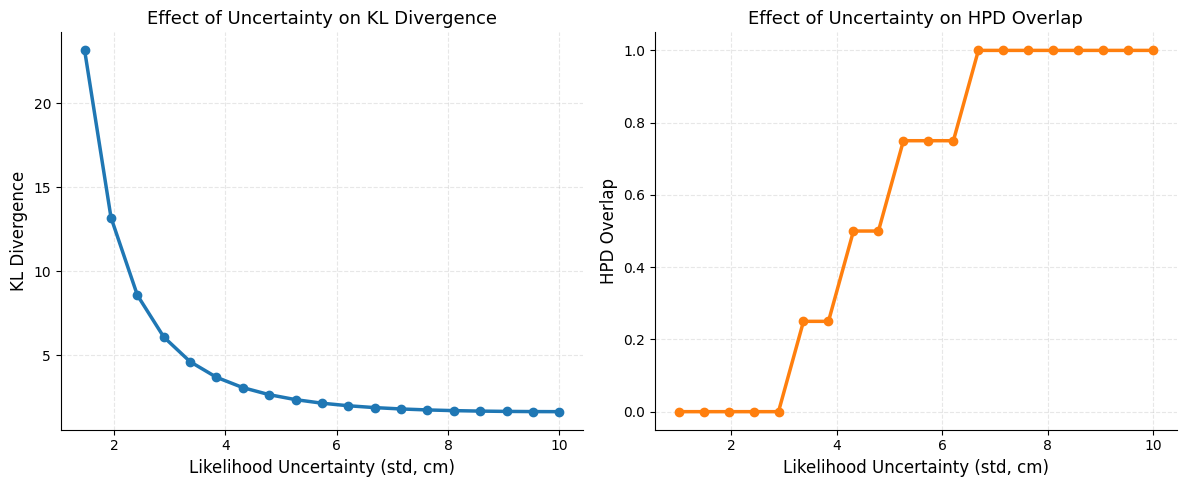

In [7]:
# Generate distributions with varying uncertainty
uncertainties = np.linspace(1.0, 10.0, 20)
kl_values_unc = []
overlap_values_unc = []

# Fixed offset
fixed_offset = 10.0

for unc in uncertainties:
    # State distribution with fixed std, likelihood with varying std
    state_test = generate_1d_gaussian_distribution(position_bins, mean=40.0, std=2.0)
    likelihood_test = generate_1d_gaussian_distribution(
        position_bins, mean=40.0 + fixed_offset, std=unc
    )

    state_test_2d = state_test[np.newaxis, :]
    likelihood_test_2d = likelihood_test[np.newaxis, :]

    kl_values_unc.append(kl_divergence(state_test_2d, likelihood_test_2d)[0])
    overlap_values_unc.append(hpd_overlap(state_test_2d, likelihood_test_2d, coverage=0.95)[0])

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(uncertainties, kl_values_unc, linewidth=2.5, marker="o", markersize=6, color="#1f77b4")
ax1.set_xlabel("Likelihood Uncertainty (std, cm)")
ax1.set_ylabel("KL Divergence")
ax1.set_title("Effect of Uncertainty on KL Divergence")

ax2.plot(
    uncertainties, overlap_values_unc, linewidth=2.5, marker="o", markersize=6, color="#ff7f0e"
)
ax2.set_xlabel("Likelihood Uncertainty (std, cm)")
ax2.set_ylabel("HPD Overlap")
ax2.set_title("Effect of Uncertainty on HPD Overlap")

plt.tight_layout()
plt.show()

### Key Observations

**As likelihood uncertainty increases:**
- **KL divergence decreases**: The distributions become more similar as the likelihood spreads out
- **HPD overlap increases then plateaus**: More spread means more spatial overlap, but eventually coverage limits are reached

**Important insight:** Model uncertainty affects diagnostic metrics. A very uncertain model might appear to "fit well" simply because it doesn't make strong predictions. This is why we need multiple complementary diagnostics!

## Summary: What We Learned

**Core concepts:**
1. State space models have latent variables we can't directly observe
2. We assess fit by comparing state distribution (model prediction) vs likelihood (data-driven)
3. Agreement indicates good fit; disagreement indicates problems

**Diagnostic metrics:**
1. **KL Divergence**: Measures information divergence
   - Low (< 0.1): Good agreement
   - High (> 1.0): Poor agreement

2. **HPD Overlap**: Measures spatial overlap of high-probability regions
   - High (> 0.7): Good spatial agreement
   - Low (< 0.3): Poor spatial agreement

**Key insights:**
- Visual inspection builds intuition
- Quantitative metrics provide objective assessment
- Multiple metrics give complementary views
- Uncertainty affects interpretation

**Next steps:**
- **Next notebook**: [02_highest_density_regions.ipynb](02_highest_density_regions.ipynb) - Deep dive into HPD regions
- **Jump ahead**: [03_time_resolved_diagnostics.ipynb](03_time_resolved_diagnostics.ipynb) - Apply to real time series data

## Exercises (Optional)

Try modifying the code above to explore these questions:

1. ⭐ **Easy**: What happens with very peaked distributions (std = 0.5)? How do KL and overlap change?
   - *Hint: Modify the `std` parameter in the distribution generation*

2. ⭐⭐ **Moderate**: How do metrics change if both distributions have high uncertainty (std > 10)?
   - *Hint: Does high mutual uncertainty make disagreement harder to detect?*

3. ⭐⭐⭐ **Advanced**: Can you create a case where KL divergence is low but overlap is also low?
   - *Hint: Think about multimodal distributions (we'll explore these in notebook 02)*